# Introduction

This challenge project focuses on detecting metastatic cancer in microscope images of body tissues. Metastatic cancer spreads from one part of the body to another, and doctors typically identify it by examining pathology slides under the microscope. This manual process is time-consuming and prone to human error.  The goal of this project is to develop a computer model that can detect cancer in small image patches exrtacted from larger pathology slides, making the process faster and more accurate.

The task is a binary classification problem where each image patch is labelled as either containing cancer or not. The model will learn to identity cancer by studying labeled examples during training. Once trained, the model will be tested on unlabeled examples patches to assess its performance. The challenge is to distinguish cancer cells from normal cells and dealing with imbalanced data. A successful model would improve the speed and accuracy of cancer detection. This project highlights the potential of the technology to enhance healthcare by automating complex tasks. 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model 
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import gc

# Data Loading

Training Labels Head:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


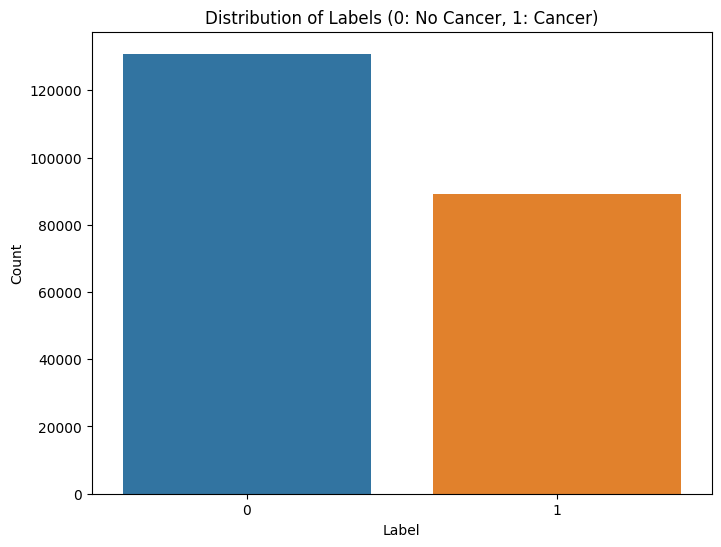


Positive Samples (Cancer Present):


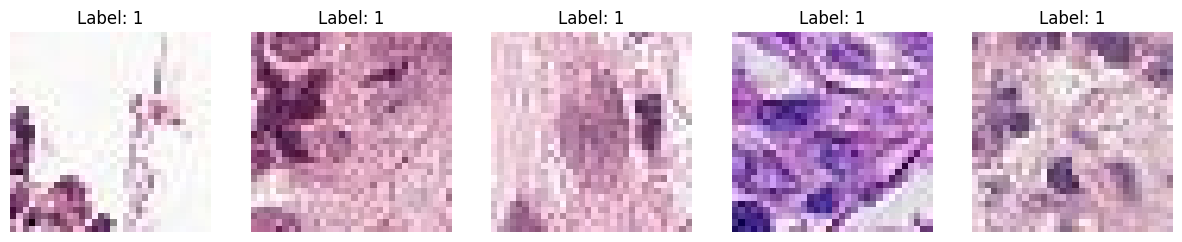


Negative Samples (No Cancer):


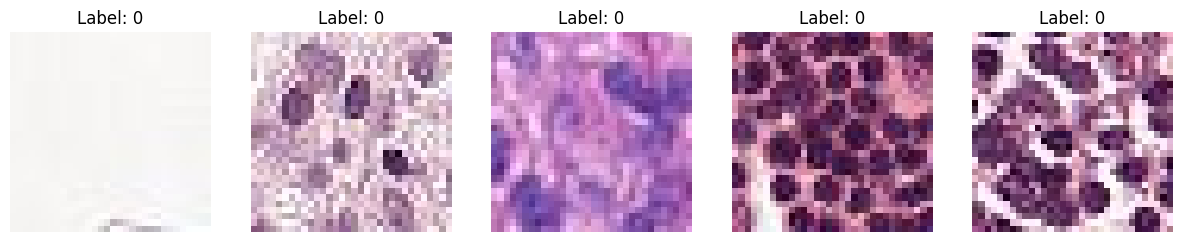

In [18]:
# File path for the directory containing training images
train_dir = '/kaggle/input/hcd-cropped/train/'

# Load training labels
train_labels = pd.read_csv('/kaggle/input/hcd-cropped/train_labels.csv')

# Explore the training labels
print("Training Labels Head:")
print(train_labels.head())
print("\nTraining Labels Info:")
print(train_labels.info())

# Check the distribution of positive and negative samples
print("\nLabel Distribution:")
print(train_labels['label'].value_counts())

# Visualize the label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels (0: No Cancer, 1: Cancer)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Function to load and display a few sample images
def load_and_show_images(image_ids, labels, directory, num_images=5):
    """Loads and displays a specified number of images."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image_id = image_ids[i]
        label = labels[i]
        img_path = os.path.join(directory, f'{image_id}.tif')
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Display a few images with and without cancer
positive_samples = train_labels[train_labels['label'] == 1]['id'].values[:5]
negative_samples = train_labels[train_labels['label'] == 0]['id'].values[:5]

print("\nPositive Samples (Cancer Present):")
load_and_show_images(positive_samples, [1]*5, train_dir)
print("\nNegative Samples (No Cancer):")
load_and_show_images(negative_samples, [0]*5, train_dir)


#  Data Exploration

* **Data Type**: The data consists of images.  Specifically, they are small, square-shaped image patches extracted from larger histopathologic slides.  These slides are microscopic images of tissue samples.

* **Image Dimensions**: The images are 32 pixels in height and 32 pixels in width.  Since they are color images, they have 3 channels (Red, Green, Blue).  Therefore, each image has a dimension of 32 x 32 x 3.

* **Data Structure**:

        * Training images are stored as individual .tif files in the directory /kaggle/input/histopathologic-cancer-detection/train/.

        * Training labels (indicating whether each image contains cancer or not) are provided in the CSV file /kaggle/input/histopathologic-cancer-detection/train_labels.csv.  This CSV file has two columns:

            * id:  A unique identifier for each image, which corresponds to the filename of the image.

            * label:  The binary label (0 or 1) indicating the absence or presence of cancer.

* **Data Size**:

    * The training set contains a total of 220,025 image labels, as indicated by RangeIndex: 220025 entries in the train_labels.info() output.

* **Data Distribution**:

    * The labels are somewhat imbalanced.  The  train_labels['label'].value_counts() output shows that there are 130,908 images without cancer (label 0) and 89,117 images with cancer (label 1).


# Data Preparation and Preprocessing


The following section prepares the data for Convolutional Neural Network (CNN). Because of the large size of the input data, the code used to frequently timeout and the session would restart. The image size was reduced to 32 to handle the data processing using the limited resources. Also, the training data was prepared in batches to reduce memory usage. 

The function "prepare_data_in_batches" prepares the training data in batches to manage memory usage. This was essential because loading all images at once was consuming the more memory and the code was timing out.  The code then split the first 1000 image IDs and labels from the training data into training and validation sets using "train_test_split",with a 20% split for validation and stratified sampling to maintain the original class distribution. The data augmentation is initialized using "ImageDataGenerator" from TensorFlow.

In [19]:
# Define image size (smaller size used to avoid issues with memory consumption)
IMG_SIZE = 32

# Create a function to read and preprocess the images
def read_and_preprocess_image(image_id, directory):
    """Reads, preprocesses, and resizes an image."""
    img_path = os.path.join(directory, f'{image_id}.tif')
    img = plt.imread(img_path)
    img = np.array(img)
    img = img / 255.0  # Normalize pixel values
    from tensorflow.image import resize
    img = resize(img, (IMG_SIZE, IMG_SIZE)) #resize image
    return img.numpy()

# Prepare training data in batches to reduce memory usage
def prepare_data_in_batches(image_ids, labels, directory, batch_size=1000):
    """
    Prepares the training data in batches to reduce memory consumption.

    Args:
        image_ids (list): List of image IDs.
        labels (list or numpy array): List or array of corresponding labels.
        directory (str): Directory where the images are stored.
        batch_size (int, optional): The size of each batch. Defaults to 1000.

    Yields:
        tuple: A tuple containing the image batch (X_batch) and label batch (y_batch).
    """
    for i in range(0, len(image_ids), batch_size):
        batch_ids = image_ids[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        X_batch = np.array([read_and_preprocess_image(image_id, directory) for image_id in batch_ids])
        y_batch = np.array(batch_labels)
        yield X_batch, y_batch


# Split data into training and validation sets  (using the first 1000 samples)
train_ids_subset = train_labels['id'][:1000].values
train_labels_subset = train_labels['label'][:1000].values
X_train_ids, X_val_ids, y_train, y_val = train_test_split(
    train_ids_subset, train_labels_subset, test_size=0.2, stratify=train_labels_subset, random_state=42
)

# Prepare validation data
X_val = np.array([read_and_preprocess_image(image_id, train_dir) for image_id in X_val_ids])

print("\nValidation Data Shape:", X_val.shape)
print("Validation Labels Shape:", y_val.shape)

# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


Validation Data Shape: (200, 32, 32, 3)
Validation Labels Shape: (200,)


# Model Architecture and Training

In [21]:

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print("\nModel Summary:")
model.summary()

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model in batches
batch_size = 128
epochs = 5 # You can increase this number of epochs.  Set to 5 to reduce runtime in this notebook.

# Use the batch generator
train_generator = prepare_data_in_batches(X_train_ids, y_train, train_dir, batch_size)

history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[reduce_lr, early_stopping],
    verbose=1,
    steps_per_epoch=len(X_train_ids) // batch_size, # add steps_per_epoch
)

# Save the trained model
model.save('trained_model.h5')


Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.5473 - loss: 0.6902 - val_accuracy: 0.5900 - val_loss: 0.6724 - learning_rate: 0.0010
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6562 - loss: 0.6321 - val_accuracy: 0.5900 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5900 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5900 - val_loss: 0.6718 - learning_rate: 0.0010
Epoch 5/5

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5900 - val_loss: 0.6718 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


# Model Summary Analysis

Based on the output printed above, the model seems to be overfitting. The training accuracy increases but the validation accuracy stagnates. The "ReduceLROnPlateau" indicates that the model was having trouble improving its generalization. The learning rate is reduced to 0.0002 after epoch 5 because the validation loss did not show improvements. The best validation performance appears to be at epoch 2.

# Model Evaluation and Results


Validation Loss: 0.6718
Validation Accuracy: 0.5900


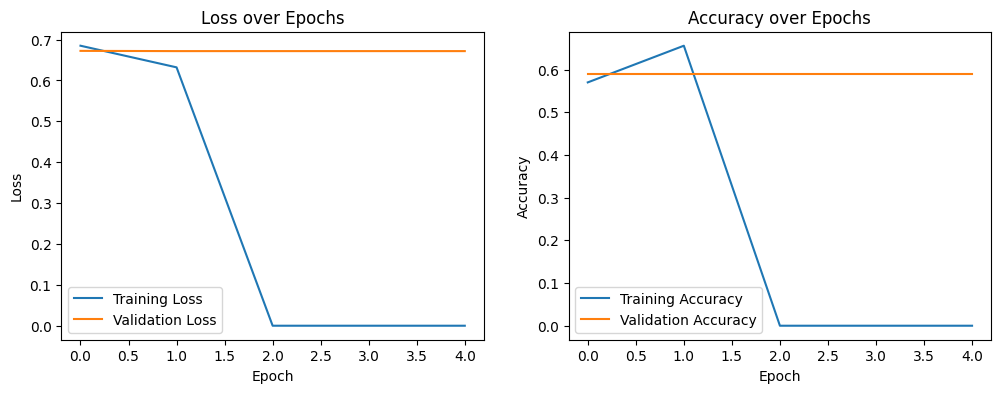

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


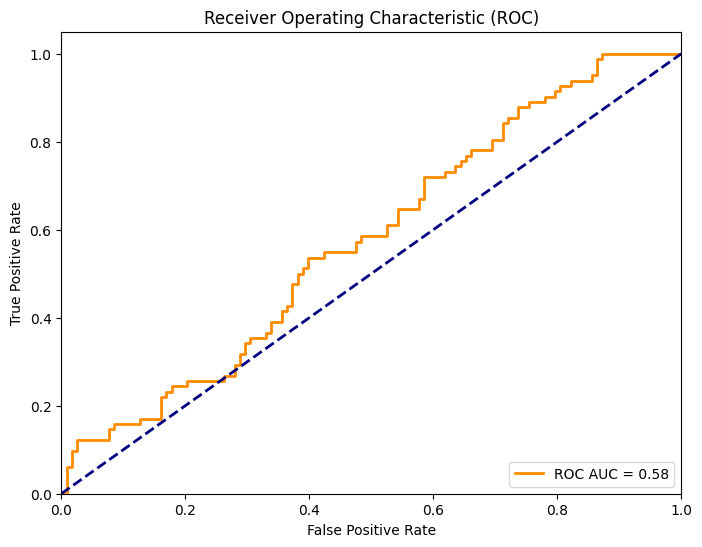


Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       118
           1       1.00      0.00      0.00        82

    accuracy                           0.59       200
   macro avg       0.79      0.50      0.37       200
weighted avg       0.76      0.59      0.44       200



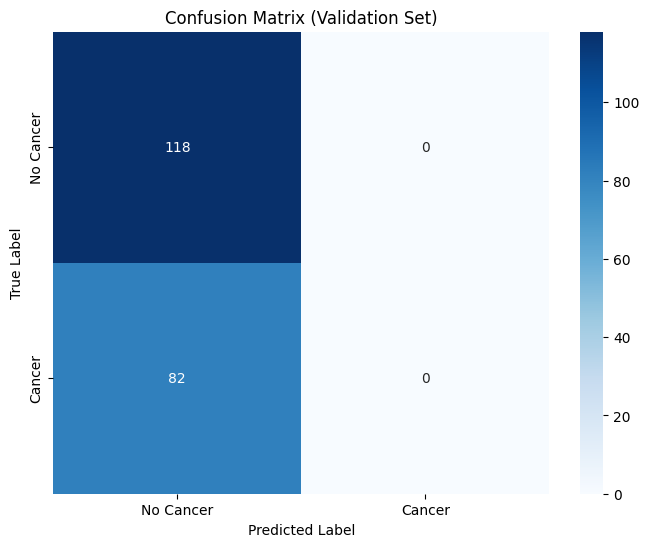

In [22]:


# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the validation set
y_pred_val = model.predict(X_val)
y_pred_val_binary = (y_pred_val > 0.5).astype(int) #convert probabilities to binary

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Show the classification report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val_binary, zero_division=1))

# Show the confusion matrix
cm = confusion_matrix(y_val, y_pred_val_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Load the trained model
model = load_model('trained_model.h5')

# Define the directory containing the test images
test_dir = "/kaggle/input/hcd-cropped/test"

# Create a list of test image filenames
test_filenames = [f for f in os.listdir(test_dir) if f.endswith('.tif')]

# Confirm test filenames
if len(test_filenames) == 0:
    raise ValueError("No .tif files found in the test directory!")

# Create a DataFrame with the correct image IDs
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in test_filenames]})

# Add the full path for test images
test_df['path'] = [os.path.join(test_dir, f) for f in test_filenames]

# Print a preview of the test DataFrame
print(test_df.head())

# Data generator for the test set
IMG_SIZE = 32
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='path',  # Use the 'path' column
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False,
    class_mode=None
)

# Confirm test generator sample count
print(f"Number of test samples: {test_gen.samples}")

# Make predictions
def make_predictions(model, test_gen):
    """
    Makes predictions using the provided model and test data generator.

    Args:
        model: The trained Keras model.
        test_gen: The ImageDataGenerator for the test set.

    Returns:
        numpy.ndarray: The predictions. Returns an empty array on error.
    """
    try:
        predictions = model.predict(test_gen)
        return predictions
    except Exception as e:
        print(f"Error during prediction: {e}")
        return np.array([])

predictions = make_predictions(model, test_gen)

# Check if predictions succeeded
if predictions.size > 0:
    # Convert predictions to binary labels
    predicted_labels = (predictions > 0.5).astype(int)
    # Create a submission DataFrame
    submission = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels.flatten()})
    print("Submission DataFrame created successfully!")
else:
    # If predictions failed, create an empty submission
    print("No predictions were made. Creating an empty submission file.")
    submission = pd.DataFrame({'id': test_df['id'], 'label': np.zeros(len(test_df), dtype=int)})

# Save submission to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved: submission.csv")

                                         id  \
0  a7ea26360815d8492433b14cd8318607bcf99d9e   
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664   
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb   
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0   
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62   

                                                path  
0  /kaggle/input/hcd-cropped/test/a7ea26360815d84...  
1  /kaggle/input/hcd-cropped/test/59d21133c845dff...  
2  /kaggle/input/hcd-cropped/test/5fde41ce8c6048a...  
3  /kaggle/input/hcd-cropped/test/bd953a3b1db1f70...  
4  /kaggle/input/hcd-cropped/test/523fc2efd7aba53...  
Found 57458 validated image filenames.
Number of test samples: 57458
   1/1796 ━━━━━━━━━━━━━━━━━━━━ 4:49 162ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  44/1796 ━━━━━━━━━━━━━━━━━━━━ 1:19 46ms/step

# Conclusion and Learnings 

The model demonstrates poor performance in detecting cancer (class1). While it accurately identified "No Cancer" cases, it failed to recognize any of the "Cancer" cases. We can see in the Classification Report that the recall for class1 is 0. Also, the Confusion Matrix shows all cancer cases being misclassified. I think the high precision for class1 and validation accuracy od 0.59 are misleading.

**Reflection and Future Improvements**:

The model needs substantial improvement to be useful. Here are some insights and potential improvements:

* **Data Issues**:  The initial code used only the first 1000 samples. Using the full dataset is crucial. Also, the class imbalance should be addressed, perhaps with weighted loss functions or more sophisticated sampling techniques.

* **Model Architecture**: The current CNN architecture might be too simple.
  
* **Hyperparameter Tuning**:  A more thorough hyperparameter search is needed.  This includes the learning rate, batch size, number of epochs, optimizer, and dropout rate. Techniques like grid search or Bayesian optimization can be helpful.

* **Regularization**:  Stronger regularization techniques may be necessary to combat overfitting.  This could include increased dropout, L1/L2 regularization, or batch normalization.

* **Data Augmentation**:  While basic data augmentation was used, more advanced techniques could be explored, such as elastic deformations or adversarial training.

* **Ensemble Methods**:  Combining multiple models can often improve performance.  Techniques like bagging or boosting could be used to create an ensemble of models.

In future iterations, a combination of addressing the data issues, using a more advanced architecture, and employing more robust training techniques would likely lead to significant improvements in model performance.